In [1]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
fname = 'BY4741_FKS1-HS1_single_ortho_anidulafungin_variant_data_merge.tsv'

min_input_readcount_high = 20
min_input_readcount_mid = 3

In [2]:
# Parameters
fname = "BY4741_FKS1-HS1_single_ortho_caspofungin_variant_data_merge.tsv"
min_input_readcount_high = 20
min_input_readcount_mid = 3


# Master notebook to analyze DMS data

## Import libraries

In [3]:
import os
import glob
import pandas as pd
import numpy as np
import math
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['svg.fonttype'] = 'none'
from upsetplot import from_indicators
from upsetplot import UpSet

## Functions

## Specify paths

In [4]:
metadata_path = 'data/'
variantdata_path = 'dimsum_output/'
expdesign_path = 'dimsum_expdesign/'
codon_table_path = 'data/general_use/ScerevisiaeTAXID559292_Cocoputs_codon_table.csv'

processed_data_outpath = 'processed_data/'
graph_outpath = 'graphs/'

## Analysis

In [5]:
f = variantdata_path+fname
pos_offset = {'FKS1-HS1': 639,
              'FKS1-HS2': 1353,
              'FKS2-HS1': 659,
              'FKS2-HS2': 1372
             }

### Get conditions from filename

In [6]:
cset = f.split('/')[-1].split('_')[:-3] # Extract conditions from name of file
cset_name = '_'.join(cset) # Basename based on conditions
strain, locus, pool_type, compound = [cset[i] for i in (0,1,2,-1)]
print(f'Strain: {strain}')
print(f'Locus: {locus}')
print(f'Pool type: {pool_type}')
print(f'Compound: {compound}')

Strain: BY4741
Locus: FKS1-HS1
Pool type: single
Compound: caspofungin


### Create output folders if they don't already exist

In [7]:
if not os.path.exists(processed_data_outpath+cset_name):
    os.makedirs(processed_data_outpath+cset_name)
if not os.path.exists(graph_outpath+cset_name):
    os.makedirs(graph_outpath+cset_name)

### Read dataframe

In [8]:
df = pd.read_csv(f, sep='\t', header=0, dtype={'WT': 'boolean'}) # Boolean type supports missing data, helps pandas interpret column content
df

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,output1caspofungin1_e1_s1_b1_count,output1caspofungin2_e1_s1_b2_count,...,output2caspofungin2_e2_s1_b2_count,output2caspofungin3_e2_s1_b3_count,input1_e1_s0_bNA_count,input2_e2_s0_bNA_count,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aagaatgttttatctttgagagatcca,KNVLSLRDP,<NA>,False,False,6.0,2.0,2.0,0,0,...,0,0,0,5,True,False,True,True,False,False
1,aagctagttttatctttgagagatcca,KLVLSLRDP,<NA>,False,False,4.0,1.0,2.0,0,0,...,0,0,0,2,True,False,True,True,False,False
2,aagctggttttatctttgagagatcca,KLVLSLRDP,<NA>,False,False,5.0,1.0,2.0,0,0,...,0,0,0,2,True,False,True,True,False,False
3,aaggtggtttcatctttgagagatcca,KVVSSLRDP,<NA>,False,False,6.0,3.0,3.0,0,1,...,1,0,0,0,True,False,True,True,False,False
4,aaggtggttttatctttgagagatcca,KVVLSLRDP,<NA>,False,False,5.0,2.0,2.0,0,0,...,0,0,0,3,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4831,ttttttgttttatctttggatgatcca,FFVLSLDDP,<NA>,False,False,4.0,2.0,2.0,0,0,...,0,0,1,0,True,False,True,True,False,False
4832,ttttttgttttatctttgtgagatcca,FFVLSL*DP,<NA>,True,False,2.0,2.0,2.0,0,0,...,0,0,1,0,True,False,True,True,False,False
4833,ttttttgttttatcttttagagatcca,FFVLSFRDP,<NA>,False,False,2.0,2.0,2.0,0,0,...,0,0,2,6,True,False,True,True,False,False
4834,tttttttctttgtcttttagagatcca,FFSLSFRDP,<NA>,False,False,5.0,3.0,4.0,0,1,...,1,0,0,0,True,False,True,True,False,False


In [9]:
# Extract sample names, based on naming pattern in experimental design file (input/output)
input_conditions = [x for x in df.columns if 'input' in x]
output_conditions = [x for x in df.columns if ('output' in x) & ('_e1_' in x)]
duplicated_output = [x for x in df.columns if ('output' in x) & ('_e1_' not in x)]
input_samples = [x.split('_')[0] for x in input_conditions]
output_samples = [x.split('_')[-2] for x in output_conditions]
conditions = input_samples+output_samples
print(conditions)

['input1', 'input2', 'b1', 'b2', 'b3']


#### /!\ **Filtering step** /!\ - Formatting

In [10]:
# Drop redundant columns due to duplicates in experimental design file
df.drop(columns=duplicated_output, inplace=True)
df.rename(columns=lambda x: x.split('_')[0] if 'input' in x else x, inplace=True)
df.rename(columns=lambda x: x.split('_')[-2] if 'output' in x else x, inplace=True)

In [11]:
# Extract WT sequences (nucleotide and protein)
wtseq = df.loc[df.WT==True, 'nt_seq'].values[0]
wtaa = df.loc[df.WT==True, 'aa_seq'].values[0]
print(f'WT (nt): {wtseq} | (aa): {wtaa}')

WT (nt): tttttagttttatctttgagagatcca | (aa): FLVLSLRDP


### Mean readcount per variant (raw data)

This matrix shows the average readcount per unique nucleotide sequence per number of mutated codons across samples.

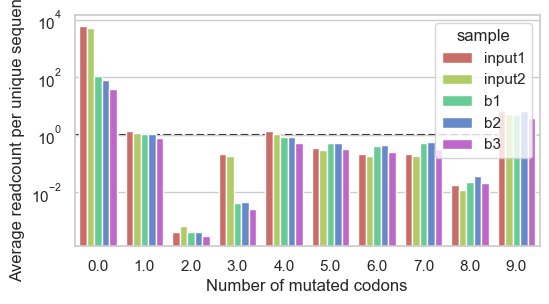

In [12]:
# Purge graph space
sns.set(rc = {'figure.figsize':(6,3)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

count_per_mut_codon = df.groupby('Nmut_codons')[conditions].count()
mean_rc_per_variant = df.groupby('Nmut_codons')[conditions].mean() / count_per_mut_codon
mean_rc_per_variant.reset_index(inplace=True)
mean_rc_long = mean_rc_per_variant.melt(id_vars=['Nmut_codons'], value_vars=conditions, var_name='sample')
sns.barplot(mean_rc_long, x='Nmut_codons',y='value',hue='sample',palette='hls')
plt.yscale('log')
plt.ylabel('Average readcount per unique sequence')
plt.xlabel('Number of mutated codons')
plt.axhline(y=1, linestyle='--', c='k', zorder=-10)

### Overrepresented variants (raw data)

The table below shows the 5 most represented sequences (mean readcount across samples) in % read depth per sample.

#### Overrepresented variants in input samples

In [13]:
overrep_index = df[input_samples].mean(axis=1).sort_values(ascending=False).index[:5]
overrep = 100*round(df.iloc[overrep_index][conditions] / df[conditions].sum(axis=0), 4)
pd.concat([overrep, df.iloc[overrep_index][['nt_seq', 'aa_seq', 'Nmut_codons']]], axis=1)

,input1,input2,b1,b2,b3,nt_seq,aa_seq,Nmut_codons
3692,3.08,2.86,0.07,0.05,0.04,tttttagttttatctttgagagatcca,FLVLSLRDP,0.0
2006,1.10,1.09,0.01,0.01,0.01,tttttaatgttatctttgagagatcca,FLMLSLRDP,1.0
4826,1.14,1.01,0.01,0.01,0.02,ttttttgttttatctttgagagatcca,FFVLSLRDP,1.0
1468,0.94,0.96,0.02,0.02,0.01,tttcaggttttatctttgagagatcca,FQVLSLRDP,1.0
1887,0.85,1.03,0.18,0.18,0.18,ttttctgttttatctttgagagatcca,FSVLSLRDP,1.0


#### Overrepresented variants in output samples

In [14]:
overrep_index = df[output_samples].mean(axis=1).sort_values(ascending=False).index[:5]
overrep = 100*round(df.iloc[overrep_index][conditions] / df[conditions].sum(axis=0), 4)
pd.concat([overrep, df.iloc[overrep_index][['nt_seq', 'aa_seq', 'Nmut_codons']]], axis=1)

,input1,input2,b1,b2,b3,nt_seq,aa_seq,Nmut_codons
3841,0.76,0.75,1.88,2.01,1.99,tttttagttttatctttgagatgtcca,FLVLSLRCP,1.0
3742,0.77,0.76,1.67,1.65,1.77,tttttagttttatctttgagagatttt,FLVLSLRDF,1.0
2762,0.80,0.71,1.65,1.62,1.71,tttttagttttaacgttgagagatcca,FLVLTLRDP,1.0
2840,0.67,0.66,1.58,1.65,1.68,tttttagttttacagttgagagatcca,FLVLQLRDP,1.0
1229,0.47,0.40,1.48,1.55,1.32,ttgcaaattagaccattgattgctcca,LQIRPLIAP,7.0


### Calculate % read depth per sample corresponding to variants with no indels + read count above threshold

In [15]:
# Sum all reads for each sample
# Check proportion that corresponds to variants with no indels
rcNoIndel = df[conditions].sum(axis=0).to_frame('Total_reads')
rcNoIndel['Reads_no_indels'] = df[df.indel == False][conditions].sum(axis=0)
rcNoIndel['Reads_no_indels_%'] = 100*round(rcNoIndel['Reads_no_indels']/rcNoIndel['Total_reads'], 3)

# Check proportion that corresponds to variants with a read count above threshold in all input samples
# Here we only show the variant surpassing the highest threshold = variants which will be labeled with a high confidence score
rcNoIndel['No_indels_acceptable_RC'] = df[((df[input_samples] > min_input_readcount_high).all(1)) & (df.indel == False)][conditions].sum(axis=0)
rcNoIndel['Acceptable_RC_over_no_indels_%'] = 100*round(rcNoIndel['No_indels_acceptable_RC']/rcNoIndel['Reads_no_indels'], 3)

# Export summary to csv
rcNoIndel.to_csv(processed_data_outpath+cset_name+'/read_count_no_indel.csv')
rcNoIndel

,Total_reads,Reads_no_indels,Reads_no_indels_%,No_indels_acceptable_RC,Acceptable_RC_over_no_indels_%
input1,203007,202006,99.5,200656,99.3
input2,175711,173890,99.0,169578,97.5
b1,165182,164680,99.7,163550,99.3
b2,173171,172660,99.7,171663,99.4
b3,113261,112901,99.7,112110,99.3


#### /!\ **Filtering step** /!\ - Discard variants with indels

In [16]:
# Keeping only variants with no indels
df.drop(df[df.indel].index, inplace=True)
df.reset_index(drop=True, inplace=True)
df

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,b1,b2,b3,input1,input2,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aagaatgttttatctttgagagatcca,KNVLSLRDP,<NA>,False,False,6.0,2.0,2.0,0,0,0,0,5,True,False,True,True,False,False
1,aagctagttttatctttgagagatcca,KLVLSLRDP,<NA>,False,False,4.0,1.0,2.0,0,0,0,0,2,True,False,True,True,False,False
2,aagctggttttatctttgagagatcca,KLVLSLRDP,<NA>,False,False,5.0,1.0,2.0,0,0,0,0,2,True,False,True,True,False,False
3,aaggtggtttcatctttgagagatcca,KVVSSLRDP,<NA>,False,False,6.0,3.0,3.0,0,1,0,0,0,True,False,True,True,False,False
4,aaggtggttttatctttgagagatcca,KVVLSLRDP,<NA>,False,False,5.0,2.0,2.0,0,0,0,0,3,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4136,ttttttgttttatctttgatggatcca,FFVLSLMDP,<NA>,False,False,3.0,2.0,2.0,0,0,0,0,1,True,False,True,True,False,False
4137,ttttttgttttatctttggatgatcca,FFVLSLDDP,<NA>,False,False,4.0,2.0,2.0,0,0,0,1,0,True,False,True,True,False,False
4138,ttttttgttttatctttgtgagatcca,FFVLSL*DP,<NA>,True,False,2.0,2.0,2.0,0,0,0,1,0,True,False,True,True,False,False
4139,ttttttgttttatcttttagagatcca,FFVLSFRDP,<NA>,False,False,2.0,2.0,2.0,0,0,0,2,6,True,False,True,True,False,False


#### /!\ **Filtering step** /!\ - Keep only variants with at least 3 reads in at least 1 input replicate

In [17]:
inputRCdf = df[(df[input_samples] > 2).any(axis=1)]
inputRCdf

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,b1,b2,b3,input1,input2,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions
0,aagaatgttttatctttgagagatcca,KNVLSLRDP,<NA>,False,False,6.0,2.0,2.0,0,0,0,0,5,True,False,True,True,False,False
4,aaggtggttttatctttgagagatcca,KVVLSLRDP,<NA>,False,False,5.0,2.0,2.0,0,0,0,0,3,True,False,True,True,False,False
6,aagttaccgttatctttgagagatcca,KLPLSLRDP,<NA>,False,False,6.0,2.0,2.0,0,0,0,0,3,True,False,True,True,False,False
7,aagttagttacgtctttgagagatcca,KLVTSLRDP,<NA>,False,False,6.0,2.0,2.0,0,0,0,0,5,True,False,True,True,False,False
8,aagttagttttaactttgagagatcca,KLVLTLRDP,<NA>,False,False,4.0,2.0,2.0,0,0,0,0,5,True,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4125,ttttttgttttatctttgagacctcca,FFVLSLRPP,<NA>,False,False,3.0,2.0,2.0,0,0,0,0,7,True,False,True,True,False,False
4127,ttttttgttttatctttgagagataag,FFVLSLRDK,<NA>,False,False,4.0,2.0,2.0,0,2,1,0,7,True,False,True,True,False,False
4128,ttttttgttttatctttgagagataca,FFVLSLRDT,<NA>,False,False,2.0,2.0,2.0,0,0,0,3,5,True,False,True,True,False,False
4132,ttttttgttttatctttgagagatcca,FFVLSLRDP,<NA>,False,False,1.0,1.0,1.0,11,24,20,2317,1766,True,False,True,True,False,False


### Label variants with confidence score (related to readcount)

In [18]:
def get_confidence_score(g, thresh_high, thresh_mid):
    # The read count in all input replicates is parsed to label each variant with a confidence score
    # Score is an integer for easy aggregation of synonymous codons
    if (g > thresh_high).all():
        return 1 # high confidence score
    elif (g > thresh_mid).all():
        return 2 # medium confidence score
    else:
        return 3 # low confidence score

In [19]:
pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
inputRCdf['confidence_score'] = inputRCdf[input_samples].apply(lambda row: get_confidence_score(row, min_input_readcount_high, min_input_readcount_mid), axis=1)
inputRCdf

,nt_seq,aa_seq,WT,STOP,STOP_readthrough,Nham_nt,Nham_aa,Nmut_codons,b1,b2,b3,input1,input2,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score
0,aagaatgttttatctttgagagatcca,KNVLSLRDP,<NA>,False,False,6.0,2.0,2.0,0,0,0,0,5,True,False,True,True,False,False,3
4,aaggtggttttatctttgagagatcca,KVVLSLRDP,<NA>,False,False,5.0,2.0,2.0,0,0,0,0,3,True,False,True,True,False,False,3
6,aagttaccgttatctttgagagatcca,KLPLSLRDP,<NA>,False,False,6.0,2.0,2.0,0,0,0,0,3,True,False,True,True,False,False,3
7,aagttagttacgtctttgagagatcca,KLVTSLRDP,<NA>,False,False,6.0,2.0,2.0,0,0,0,0,5,True,False,True,True,False,False,3
8,aagttagttttaactttgagagatcca,KLVLTLRDP,<NA>,False,False,4.0,2.0,2.0,0,0,0,0,5,True,False,True,True,False,False,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4125,ttttttgttttatctttgagacctcca,FFVLSLRPP,<NA>,False,False,3.0,2.0,2.0,0,0,0,0,7,True,False,True,True,False,False,3
4127,ttttttgttttatctttgagagataag,FFVLSLRDK,<NA>,False,False,4.0,2.0,2.0,0,2,1,0,7,True,False,True,True,False,False,3
4128,ttttttgttttatctttgagagataca,FFVLSLRDT,<NA>,False,False,2.0,2.0,2.0,0,0,0,3,5,True,False,True,True,False,False,3
4132,ttttttgttttatctttgagagatcca,FFVLSLRDP,<NA>,False,False,1.0,1.0,1.0,11,24,20,2317,1766,True,False,True,True,False,False,1


### Merge with dataframe of expected variants

In [20]:
# Dataframe containing all expected mutants for the different libraries (single, double, ortholog) is imported
# /!\ Important to note that I did not actually separate by type of library /!\
# "Double" mutants do not include single mutants
# "Ortho" are standalone (double mutants in orthologous sequences are duplicated in "double" and "ortho" seq types)
source = metadata_path+locus+f'/{locus}_var_df.csv'
vardf = pd.read_csv(source, header=0, index_col=0)
vardf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination
0,WT,tttttagttttatctttgagagatcca,NaN,NaN,NaN,NaN
1,single,ttgttagttttatctttgagagatcca,0.0,ttg,1.0,NaN
2,single,cttttagttttatctttgagagatcca,0.0,ctt,1.0,NaN
3,single,ctgttagttttatctttgagagatcca,0.0,ctg,1.0,NaN
4,single,attttagttttatctttgagagatcca,0.0,att,1.0,NaN
...,...,...,...,...,...,...
71724,ortho,tatttgactagagcttttagagattct,8.0,tct,7.0,NaN
71725,ortho,tttttggctttgtctattagagatcca,1.0,ttg,1.0,NaN
71726,ortho,tttttggctttgtctattagagatcca,2.0,gct,2.0,NaN
71727,ortho,tttttggctttgtctattagagatcca,3.0,ttg,3.0,NaN


#### /!\ **Filtering step** /!\ - Keep only mutants corresponding to pool_type

In [21]:
# Depending on the type of pool (single or double), expected variants are filtered
# The dictionary specifies which sequence types must be kept
keep_seq_type = {'single' : ['WT', 'single', 'ortho'], 'double': ['WT', 'single', 'double']}
var_filtered_df = vardf[vardf.seq_type.isin(keep_seq_type[pool_type])]
len(var_filtered_df)

541

In [22]:
len(var_filtered_df.nt_seq.unique())

334

In [23]:
# The dataframe of sequenced variants ( with no indels and readcount > threshold in all input replicates) and the dataframe of expected mutants are compared
# The column 'Location' indicates if a variant is found only in the set of expected variants (left), only in the sequenced dataset (right), or in both (covered variants)
comparedf = pd.merge(left=var_filtered_df, right=inputRCdf, how='outer', on='nt_seq', indicator='Location')
comparedf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,input1,input2,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score,Location
0,WT,tttttagttttatctttgagagatcca,NaN,NaN,NaN,NaN,FLVLSLRDP,True,False,False,...,6257.0,5030.0,True,False,True,True,False,False,1.0,both
1,single,ttgttagttttatctttgagagatcca,0.0,ttg,1.0,NaN,LLVLSLRDP,<NA>,False,False,...,753.0,614.0,True,False,True,True,False,False,1.0,both
2,single,cttttagttttatctttgagagatcca,0.0,ctt,1.0,NaN,LLVLSLRDP,<NA>,False,False,...,167.0,148.0,True,False,True,True,False,False,1.0,both
3,single,ctgttagttttatctttgagagatcca,0.0,ctg,1.0,NaN,LLVLSLRDP,<NA>,False,False,...,279.0,239.0,True,False,True,True,False,False,1.0,both
4,single,attttagttttatctttgagagatcca,0.0,att,1.0,NaN,ILVLSLRDP,<NA>,False,False,...,655.0,499.0,True,False,True,True,False,False,1.0,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1129,NaN,ttttttgttttatctttgagaaggcca,NaN,NaN,NaN,NaN,FFVLSLRRP,<NA>,False,False,...,0.0,5.0,True,False,True,True,False,False,3.0,right_only
1130,NaN,ttttttgttttatctttgagacctcca,NaN,NaN,NaN,NaN,FFVLSLRPP,<NA>,False,False,...,0.0,7.0,True,False,True,True,False,False,3.0,right_only
1131,NaN,ttttttgttttatctttgagagataag,NaN,NaN,NaN,NaN,FFVLSLRDK,<NA>,False,False,...,0.0,7.0,True,False,True,True,False,False,3.0,right_only
1132,NaN,ttttttgttttatctttgagagataca,NaN,NaN,NaN,NaN,FFVLSLRDT,<NA>,False,False,...,3.0,5.0,True,False,True,True,False,False,3.0,right_only


In [24]:
# From that we build a summary with number of variants and read counts across samples
# Careful, some variants and their associated reads are shared among different samples
seqdf = inputRCdf[conditions].astype(bool).sum(axis=0).to_frame('Filtered_sequenced_variants') # No duplicates in this dataframe - corresponds to sequenced variants (expected AND unexpected)
seqdf['Filtered_sequenced_variants_rc'] = inputRCdf[conditions].sum(axis=0)
seqdf['Usable_variants'] = comparedf[comparedf.Location.str.contains('both')].groupby('nt_seq')[conditions].first().astype(bool).sum(axis=0)
# Below we calculate how many variants (of the proper seq type) are found in our sequencing dataset after filtering steps
# Only the highest percentage value is relevant, since variants are shared between input and output samples (some of them being depleted after selection)
# Expected but unsequenced variants might have been absent from our initial libraries of mutants
seqdf['Covered_variants_%'] = 100*round(seqdf['Usable_variants']/len(var_filtered_df.nt_seq.unique()),3)
seqdf['Usable_variants_rc'] = comparedf[comparedf.Location.str.contains('both')].groupby('nt_seq')[conditions].first().sum(axis=0)
seqdf['Usable_variants_%rc'] = 100*round(seqdf['Usable_variants_rc']/seqdf['Filtered_sequenced_variants_rc'],3)
seqdf['Unsequenced_variants'] = comparedf[comparedf.Location.str.contains('left')].groupby('nt_seq')[conditions].first().astype(bool).sum(axis=0)
# Readcount for unsequenced variants is by definition = 0
seqdf['Unexpected_variants'] = comparedf[comparedf.Location.str.contains('right')][conditions].astype(bool).sum(axis=0)
seqdf['Unexpected_variants_rc'] = comparedf[comparedf.Location.str.contains('right')][conditions].sum(axis=0)
# %Readcount for unexpected variants is always 100 - %rc for covered variants

# Export summary
seqdf.to_csv(processed_data_outpath+cset_name+'/detected_variants.csv')
seqdf

,Filtered_sequenced_variants,Filtered_sequenced_variants_rc,Usable_variants,Covered_variants_%,Usable_variants_rc,Usable_variants_%rc,Unsequenced_variants,Unexpected_variants,Unexpected_variants_rc
input1,398,201004,313,93.7,197362.0,98.2,18,85,3642.0
input2,879,172105,315,94.3,166685.0,96.9,18,564,5420.0
b1,400,163683,296,88.6,158993.0,97.1,18,104,4690.0
b2,371,171750,294,88.0,166901.0,97.2,18,77,4849.0
b3,359,112183,290,86.8,108901.0,97.1,18,69,3282.0


### Read counts on **sequenced** variants

#### /!\ **Filtering step** /!\ - Keep only expected variants

In [25]:
pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
covereddf = comparedf[comparedf.Location.str.contains('both')].reset_index(drop=True)
covereddf[covereddf.duplicated(subset='nt_seq', keep=False)].head(5)

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,input1,input2,barcode_valid,indel,constant_region,permitted,too_many_substitutions,mixed_substitutions,confidence_score,Location
267,ortho,gctatttgttctgatttgagagaagat,0.0,gct,1.0,NaN,AICSDLRED,<NA>,False,False,...,393.0,353.0,True,False,True,True,False,False,1.0,both
268,ortho,gctatttgttctgatttgagagaagat,1.0,att,2.0,NaN,AICSDLRED,<NA>,False,False,...,393.0,353.0,True,False,True,True,False,False,1.0,both
269,ortho,gctatttgttctgatttgagagaagat,2.0,tgt,3.0,NaN,AICSDLRED,<NA>,False,False,...,393.0,353.0,True,False,True,True,False,False,1.0,both
270,ortho,gctatttgttctgatttgagagaagat,3.0,tct,4.0,NaN,AICSDLRED,<NA>,False,False,...,393.0,353.0,True,False,True,True,False,False,1.0,both
271,ortho,gctatttgttctgatttgagagaagat,4.0,gat,5.0,NaN,AICSDLRED,<NA>,False,False,...,393.0,353.0,True,False,True,True,False,False,1.0,both


In [26]:
cov_upset = covereddf.groupby('nt_seq').agg(dict(zip(conditions+['seq_type', 'confidence_score'], ['first']*(len(conditions)+2))))
cov_upset['mean_input'] = np.log10(cov_upset[input_samples].mean(axis=1).add(1))
cov_upset['mean_output'] = np.log10(cov_upset[output_samples].mean(axis=1).add(1))
cov_upset

,input1,input2,b1,b2,b3,seq_type,confidence_score,mean_input,mean_output
nt_seq,,,,,,,,,
aagttagttttatctttgagagatcca,380.0,335.0,735.0,973.0,562.0,single,1.0,2.554489,2.879478
aatttagttttatctttgagagatcca,35.0,41.0,40.0,7.0,21.0,single,1.0,1.591065,1.374137
acgttagttttatctttgagagatcca,48.0,23.0,17.0,15.0,24.0,single,1.0,1.562293,1.293731
actttagttttatctttgagagatcca,677.0,537.0,1307.0,1406.0,960.0,single,1.0,2.783904,3.088254
aggttagttttatctttgagagatcca,48.0,50.0,139.0,167.0,86.0,single,1.0,1.698970,2.119476
...,...,...,...,...,...,...,...,...,...
tttttggctttgtcttttagagatgct,1031.0,900.0,2254.0,2187.0,1463.0,ortho,1.0,2.985202,3.294246
tttttggttttatctttgagagatcca,1541.0,1221.0,14.0,9.0,10.0,single,1.0,3.140508,1.079181
tttttggttttgtctttgagagatcca,469.0,279.0,2.0,3.0,2.0,ortho,1.0,2.574031,0.522879


In [27]:
cov_upset.groupby('confidence_score').size()

confidence_score
1.0    298
2.0      5
3.0     13
dtype: int64

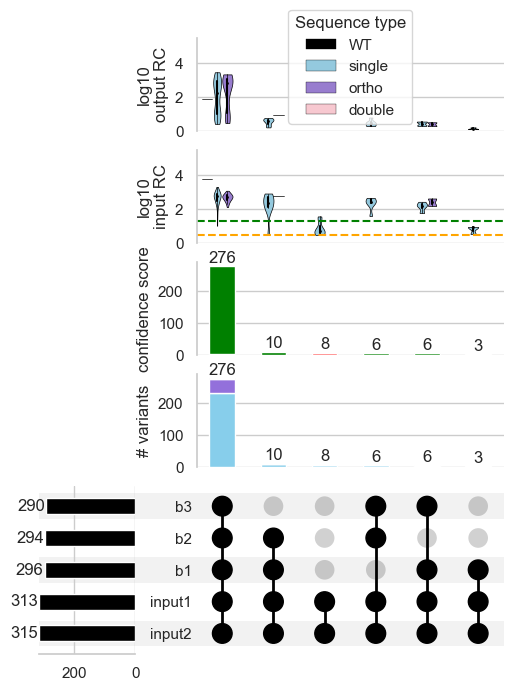

In [28]:
cov_upset[conditions] = cov_upset[conditions].astype(bool)
seq_types = ['WT', 'single', 'ortho', 'double']
seq_type_colors = ['black', 'skyblue', 'mediumpurple', 'pink']
cscores = [1,2,3]
cscore_colors = ['green','orange','red']

if pool_type == 'single':
    min_sub = 3
else:
    min_sub = 100

fig = plt.figure(figsize=(6, 8))
upset_obj = UpSet(from_indicators(conditions, data=cov_upset),
                   #show_percentages=True,
                   show_counts=True,
                   min_subset_size=min_sub,
                   sort_by='cardinality',
                   element_size=None,
                   intersection_plot_elements=0, # height of intersection barplot in matrix elements
                   totals_plot_elements = 2 # width of totals barplot in matrix elements
                  )

upset_obj.add_stacked_bars(by='seq_type',
                           colors=dict(zip(seq_types, seq_type_colors)),
                           elements=3
                          )

upset_obj.add_stacked_bars(by='confidence_score',
                           colors=dict(zip(cscores, cscore_colors)),
                           elements=3
                          )

upset_obj.add_catplot(value='mean_input', kind='violin', cut=0, bw=0.5,
                      hue='seq_type', hue_order=seq_types, palette=seq_type_colors,
                      linewidth=0.5,
                      elements=3 # height in number of matrix elements
                      )

upset_obj.add_catplot(value='mean_output', kind='violin', cut=0, bw=0.5,
                      hue='seq_type', hue_order=seq_types, palette=seq_type_colors,
                      linewidth=0.5,
                      elements=3 # height in number of matrix elements
                      )

d = upset_obj.plot(fig=fig) # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by upset_obj.make_grid()
ax0 = d['extra0'] # Key corresponding to 1st stacked barplot - type of sequence ('intersections' = intersection barplot)
ax1 = d['extra1'] # Key corresponding to 2nd stacked barplot (confidence score)
ax2 = d['extra2'] # Key corresponding to 1st catplot - read count for input samples
ax3 = d['extra3'] # Key corresponding to 2nd catplot - read count for output samples
ax0.legend().remove()
ax0.set_ylabel('# variants') # (unique nucleotide sequences)

ax1.legend().remove()
ax1.set_ylabel('confidence score')

ax2.legend().remove()
ax2.set(ylim=(0,5.5))
ax2.set_ylabel('log10\ninput RC')
ax2.axhline(y=np.log10(min_input_readcount_mid), linestyle='--', color=cscore_colors[1])
ax2.axhline(y=np.log10(min_input_readcount_high), linestyle='--', color=cscore_colors[0])

ax3.set(ylim=(0,5.5))
ax3.set_ylabel('log10\noutput RC')
ax3.legend(title='Sequence type')

plt.savefig(graph_outpath+cset_name+'/upset_variants_rc.svg', format='svg', dpi=300)

In [29]:
totrc = covereddf.groupby('nt_seq')[conditions].first().sum(axis=0).to_frame('total_readcount')
totrc['WT'] = covereddf[covereddf.WT==True][conditions].squeeze()
totrc['WT_%'] = 100*round(totrc['WT'] / totrc['total_readcount'], 3)
totrc['single_mut_readcount'] = covereddf[covereddf.seq_type=='single'].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['single_mut_readcount_%'] = 100*round(totrc['single_mut_readcount'] / totrc['total_readcount'], 3)
totrc['ortho_mut_readcount'] = covereddf[covereddf.seq_type=='ortho'].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['ortho_mut_readcount_%'] = 100*round(totrc['ortho_mut_readcount'] / totrc['total_readcount'], 3)
totrc['double_mut_readcount'] = covereddf[covereddf.seq_type=='double'].groupby('nt_seq')[conditions].first().sum(axis=0)
totrc['double_mut_readcount_%'] = 100*round(totrc['double_mut_readcount'] / totrc['total_readcount'], 3)
        
# Export summary - unexpected variants can have arisen through sequencing errors
totrc.to_csv(processed_data_outpath+cset_name+'/readcount_per_library.csv')
totrc

,total_readcount,WT,WT_%,single_mut_readcount,single_mut_readcount_%,ortho_mut_readcount,ortho_mut_readcount_%,double_mut_readcount,double_mut_readcount_%
input1,197362.0,6257.0,3.2,162592.0,82.4,28513.0,14.4,0.0,0.0
input2,166685.0,5030.0,3.0,137866.0,82.7,23789.0,14.3,0.0,0.0
b1,158993.0,115.0,0.1,123471.0,77.7,35407.0,22.3,0.0,0.0
b2,166901.0,80.0,0.0,128891.0,77.2,37930.0,22.7,0.0,0.0
b3,108901.0,40.0,0.0,86746.0,79.7,22115.0,20.3,0.0,0.0


The following is particularly important.

We add 1 read to all read counts to not have any null values (because of the dataframe's wide format).

Later on, when the selection coefficient is calculated, a zero could either mean that:

1. the sequence wasn't in the pool at t0
2. the sequence was in the pool at t0 but was not sequenced because of a low coverage
3. the sequence was so deleterious upon selective pressure that it is no longer sequenced at later timepoints

In [30]:
#pd.set_option('mode.chained_assignment', None) # Disable settingWithCopy warning
covereddf[conditions] += 1
covereddf[conditions]

,input1,input2,b1,b2,b3
0,6258.0,5031.0,116.0,81.0,41.0
1,754.0,615.0,846.0,844.0,613.0
2,168.0,149.0,208.0,212.0,136.0
3,280.0,240.0,280.0,303.0,176.0
4,656.0,500.0,1237.0,1286.0,837.0
...,...,...,...,...,...
513,630.0,625.0,1511.0,1618.0,955.0
514,635.0,499.0,6.0,9.0,4.0
515,635.0,499.0,6.0,9.0,4.0
516,635.0,499.0,6.0,9.0,4.0


### Calculate frequencies (relative abundance of each variant)

In [31]:
abund = covereddf[conditions].div(covereddf.groupby('nt_seq')[conditions].first().sum(axis=0), axis=1)
abund.rename(columns=lambda x: x+'_abundance', inplace=True)
abund_conditions = [x+'_abundance' for x in conditions]

# Abundance values are added as columns on the existing dataframe
abundf = pd.concat([covereddf, abund], axis=1)
        
# Export dataframe
abundf.to_csv(processed_data_outpath+cset_name+'/abundance_all_libraries.csv')
#>>>>> DATAFRAME TO VISUALIZE DISTRIBUTION OF FREQUENCIES
abundf[abund_conditions]

,input1_abundance,input2_abundance,b1_abundance,b2_abundance,b3_abundance
0,0.031658,0.030126,0.000728,0.000484,0.000375
1,0.003814,0.003683,0.005310,0.005047,0.005613
2,0.000850,0.000892,0.001306,0.001268,0.001245
3,0.001416,0.001437,0.001758,0.001812,0.001611
4,0.003319,0.002994,0.007765,0.007691,0.007664
...,...,...,...,...,...
513,0.003187,0.003742,0.009485,0.009676,0.008744
514,0.003212,0.002988,0.000038,0.000054,0.000037
515,0.003212,0.002988,0.000038,0.000054,0.000037
516,0.003212,0.002988,0.000038,0.000054,0.000037


### Visualize distribution of frequencies

#### Convert to log10

In [32]:
log10_conditions = [x.replace('abundance', 'log10') for x in abund_conditions]
abundf[log10_conditions] = abundf[abund_conditions].transform(func='log10')

#### Conditions --> long format

In [33]:
abundlong = pd.melt(abundf.groupby(['nt_seq', 'seq_type'])[log10_conditions].first().reset_index(),
                    id_vars=['nt_seq','seq_type'], value_vars=log10_conditions, var_name='sample_id', value_name='abundance')
abundlong

,nt_seq,seq_type,sample_id,abundance
0,aagttagttttatctttgagagatcca,single,input1_log10,-2.715033
1,aatttagttttatctttgagagatcca,single,input1_log10,-3.739656
2,acgttagttttatctttgagagatcca,single,input1_log10,-3.605762
3,actttagttttatctttgagagatcca,single,input1_log10,-2.464729
4,aggttagttttatctttgagagatcca,single,input1_log10,-3.605762
...,...,...,...,...
1575,tttttggctttgtcttttagagatgct,ortho,b3_log10,-1.872749
1576,tttttggttttatctttgagagatcca,single,b3_log10,-3.996898
1577,tttttggttttgtctttgagagatcca,ortho,b3_log10,-4.561169
1578,tttttgtctttgtcttttagagatcca,ortho,b3_log10,-2.870973


C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\seaborn\utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


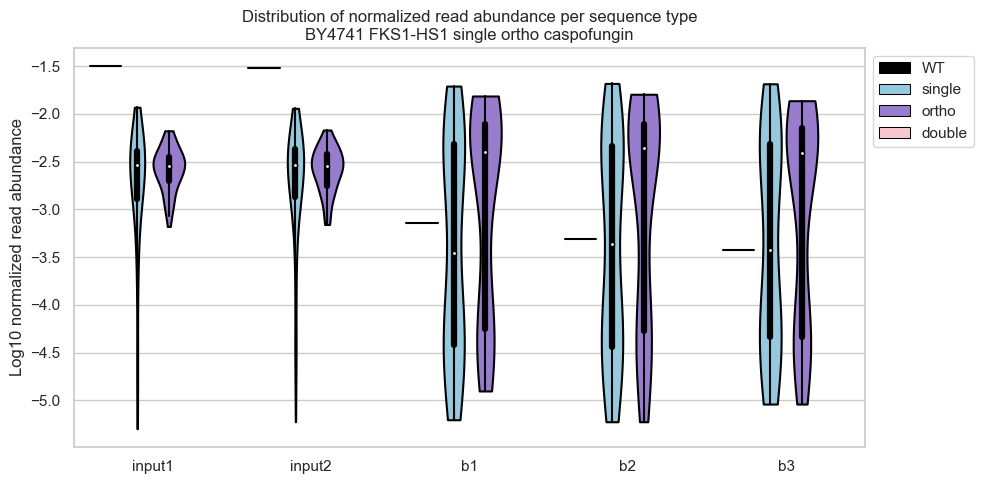

In [34]:
# Purge graph space
sns.set(rc = {'figure.figsize':(10,5)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

# Generate graph
fig = sns.violinplot(data=abundlong, x='sample_id', y='abundance',
                     hue='seq_type', hue_order=['WT', 'single', 'ortho', 'double'], palette=['black', 'skyblue', 'mediumpurple', 'pink'],
                     cut=0, # To make sure violins do not extend past the value range (because of log scale)
                     bw=0.5) # Bandwidth set to 0.5 to prevent oversmoothing

# Move legend
handles, labels = fig.get_legend_handles_labels()
sns.move_legend(fig, bbox_to_anchor=(1, 1), loc='upper left', title=None, frameon=True, handles=handles, labels=labels)

fig.axes.set(xlabel='', ylabel='Log10 normalized read abundance')
fig.set_xticklabels([x.split('_')[0] for x in abundlong.sample_id.unique()])
plt.title('Distribution of normalized read abundance per sequence type'+
         '\n'+' '.join(cset))
plt.tight_layout()

# Save graph to outpath
plt.savefig(graph_outpath+cset_name+'/abundance_distri.svg', format='svg', dpi=300)

### Add alt aminoacid and mutation type (synonymous / non-synonymous)

In [35]:
def get_mutation_type(alt, wt_aa, pos):
    if alt == wt_aa[int(pos)]:
        return 'synonymous'
    elif alt == '*':
        return 'stop'
    else:
        return 'non-synonymous'

In [36]:
abundf['alt_aa'] = abundf[abundf.seq_type != 'WT'].apply(lambda row: row['aa_seq'][int(row['aa_pos'])], axis=1)
abundf['mutation_type'] = abundf[abundf.seq_type != 'WT'].apply(lambda row: get_mutation_type(row.alt_aa, wtaa, row.aa_pos), axis=1)
abundf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,b1_abundance,b2_abundance,b3_abundance,input1_log10,input2_log10,b1_log10,b2_log10,b3_log10,alt_aa,mutation_type
0,WT,tttttagttttatctttgagagatcca,NaN,NaN,NaN,NaN,FLVLSLRDP,True,False,False,...,0.000728,0.000484,0.000375,-1.499523,-1.521065,-3.137782,-3.314795,-3.425506,NaN,NaN
1,single,ttgttagttttatctttgagagatcca,0.0,ttg,1.0,NaN,LLVLSLRDP,<NA>,False,False,...,0.005310,0.005047,0.005613,-2.418587,-2.433844,-2.274870,-2.296938,-2.250830,L,non-synonymous
2,single,cttttagttttatctttgagagatcca,0.0,ctt,1.0,NaN,LLVLSLRDP,<NA>,False,False,...,0.001306,0.001268,0.001245,-3.070649,-3.049533,-2.884177,-2.896945,-2.904751,L,non-synonymous
3,single,ctgttagttttatctttgagagatcca,0.0,ctg,1.0,NaN,LLVLSLRDP,<NA>,False,False,...,0.001758,0.001812,0.001611,-2.848800,-2.842508,-2.755082,-2.741838,-2.792778,L,non-synonymous
4,single,attttagttttatctttgagagatcca,0.0,att,1.0,NaN,ILVLSLRDP,<NA>,False,False,...,0.007765,0.007691,0.007664,-2.479054,-2.523749,-2.109871,-2.114039,-2.115565,I,non-synonymous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
513,ortho,tatttgactagagcttttagagattct,8.0,tct,7.0,NaN,YLTRAFRDS,<NA>,False,False,...,0.009485,0.009676,0.008744,-2.496618,-2.426839,-2.022976,-2.014302,-2.058287,S,non-synonymous
514,ortho,tttttggctttgtctattagagatcca,1.0,ttg,1.0,NaN,FLALSIRDP,<NA>,False,False,...,0.000038,0.000054,0.000037,-2.493185,-2.524619,-4.424089,-4.269038,-4.436230,L,synonymous
515,ortho,tttttggctttgtctattagagatcca,2.0,gct,2.0,NaN,FLALSIRDP,<NA>,False,False,...,0.000038,0.000054,0.000037,-2.493185,-2.524619,-4.424089,-4.269038,-4.436230,A,non-synonymous
516,ortho,tttttggctttgtctattagagatcca,3.0,ttg,3.0,NaN,FLALSIRDP,<NA>,False,False,...,0.000038,0.000054,0.000037,-2.493185,-2.524619,-4.424089,-4.269038,-4.436230,L,synonymous


### Duplicate WT abundance for each position

In [37]:
# Turn WT sequence into list of codons with 0-based position
codcoord = [(i//3,wtseq[i:i+3]) for i in range(0,len(wtseq),3)]
print(codcoord)

[(0, 'ttt'), (1, 'tta'), (2, 'gtt'), (3, 'tta'), (4, 'tct'), (5, 'ttg'), (6, 'aga'), (7, 'gat'), (8, 'cca')]


In [38]:
# We create a custom list of columns to create a dataframe with WT codons
wtdf_cols = ['aa_pos', 'alt_codons', 'alt_aa', 'seq_type', 'mutation_type', 'WT', 'nt_seq', 'aa_seq']

In [39]:
# A dataframe is created with 1 row per WT codon
pos_df = pd.DataFrame([[a, codcoord[a][1], wtaa[a], 'WT', 'synonymous', True, wtseq, wtaa]
                       for a in range(0,len(wtaa))], columns=wtdf_cols)
for a in abund_conditions:
    pos_df[a] = abundf.loc[abundf.WT==True, a].values[0]
pos_df  

,aa_pos,alt_codons,alt_aa,seq_type,mutation_type,WT,nt_seq,aa_seq,input1_abundance,input2_abundance,b1_abundance,b2_abundance,b3_abundance
0,0,ttt,F,WT,synonymous,True,tttttagttttatctttgagagatcca,FLVLSLRDP,0.031658,0.030126,0.000728,0.000484,0.000375
1,1,tta,L,WT,synonymous,True,tttttagttttatctttgagagatcca,FLVLSLRDP,0.031658,0.030126,0.000728,0.000484,0.000375
2,2,gtt,V,WT,synonymous,True,tttttagttttatctttgagagatcca,FLVLSLRDP,0.031658,0.030126,0.000728,0.000484,0.000375
3,3,tta,L,WT,synonymous,True,tttttagttttatctttgagagatcca,FLVLSLRDP,0.031658,0.030126,0.000728,0.000484,0.000375
4,4,tct,S,WT,synonymous,True,tttttagttttatctttgagagatcca,FLVLSLRDP,0.031658,0.030126,0.000728,0.000484,0.000375
5,5,ttg,L,WT,synonymous,True,tttttagttttatctttgagagatcca,FLVLSLRDP,0.031658,0.030126,0.000728,0.000484,0.000375
6,6,aga,R,WT,synonymous,True,tttttagttttatctttgagagatcca,FLVLSLRDP,0.031658,0.030126,0.000728,0.000484,0.000375
7,7,gat,D,WT,synonymous,True,tttttagttttatctttgagagatcca,FLVLSLRDP,0.031658,0.030126,0.000728,0.000484,0.000375
8,8,cca,P,WT,synonymous,True,tttttagttttatctttgagagatcca,FLVLSLRDP,0.031658,0.030126,0.000728,0.000484,0.000375


In [40]:
withSyndf = pd.concat([abundf[abundf.WT.isnull()], pos_df], ignore_index=True)
withSyndf

C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\IPython\lib\pretty.py:778: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  output = repr(obj)
C:\Users\duran\AppData\Roaming\jupyterlab-desktop\jlab_server\lib\site-packages\IPython\core\formatters.py:342: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  return method()


,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,b1_abundance,b2_abundance,b3_abundance,input1_log10,input2_log10,b1_log10,b2_log10,b3_log10,alt_aa,mutation_type
0,single,ttgttagttttatctttgagagatcca,0.0,ttg,1.0,NaN,LLVLSLRDP,NaN,False,False,...,0.005310,0.005047,0.005613,-2.418587,-2.433844,-2.274870,-2.296938,-2.250830,L,non-synonymous
1,single,cttttagttttatctttgagagatcca,0.0,ctt,1.0,NaN,LLVLSLRDP,NaN,False,False,...,0.001306,0.001268,0.001245,-3.070649,-3.049533,-2.884177,-2.896945,-2.904751,L,non-synonymous
2,single,ctgttagttttatctttgagagatcca,0.0,ctg,1.0,NaN,LLVLSLRDP,NaN,False,False,...,0.001758,0.001812,0.001611,-2.848800,-2.842508,-2.755082,-2.741838,-2.792778,L,non-synonymous
3,single,attttagttttatctttgagagatcca,0.0,att,1.0,NaN,ILVLSLRDP,NaN,False,False,...,0.007765,0.007691,0.007664,-2.479054,-2.523749,-2.109871,-2.114039,-2.115565,I,non-synonymous
4,single,atgttagttttatctttgagagatcca,0.0,atg,1.0,NaN,MLVLSLRDP,NaN,False,False,...,0.000069,0.000054,0.000073,-2.501470,-2.487919,-4.160848,-4.269038,-4.135200,M,non-synonymous
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,WT,tttttagttttatctttgagagatcca,4.0,tct,NaN,NaN,FLVLSLRDP,True,NaN,NaN,...,0.000728,0.000484,0.000375,NaN,NaN,NaN,NaN,NaN,S,synonymous
522,WT,tttttagttttatctttgagagatcca,5.0,ttg,NaN,NaN,FLVLSLRDP,True,NaN,NaN,...,0.000728,0.000484,0.000375,NaN,NaN,NaN,NaN,NaN,L,synonymous
523,WT,tttttagttttatctttgagagatcca,6.0,aga,NaN,NaN,FLVLSLRDP,True,NaN,NaN,...,0.000728,0.000484,0.000375,NaN,NaN,NaN,NaN,NaN,R,synonymous
524,WT,tttttagttttatctttgagagatcca,7.0,gat,NaN,NaN,FLVLSLRDP,True,NaN,NaN,...,0.000728,0.000484,0.000375,NaN,NaN,NaN,NaN,NaN,D,synonymous


### Pair input/output samples

In [41]:
input_conditions = [x for x in abund_conditions if 'input' in x]
output_conditions = [x for x in abund_conditions if x not in input_conditions]
inpoutp_tuples = [(x, y) for x in input_conditions for y in output_conditions if x.split('_')[0][-1] == y.split('_')[0][-1]]
print(inpoutp_tuples)

[('input1_abundance', 'b1_abundance'), ('input2_abundance', 'b2_abundance')]


### Calculate log2 fold-change (WT=0)

In [42]:
log2FC_conditions = ['Log2FC_'+ x[0].split('_')[0][-1] for x in inpoutp_tuples]
for i, v in enumerate(log2FC_conditions):
    withSyndf[v] = withSyndf[abund_conditions].apply(lambda row: math.log2(row[inpoutp_tuples[i][1]]/row[inpoutp_tuples[i][0]]), axis=1)
withSyndf[log2FC_conditions]

,Log2FC_1,Log2FC_2
0,0.477418,0.454792
1,0.619447,0.506887
2,0.311325,0.334419
3,1.226402,1.361026
4,-5.512332,-5.916748
...,...,...
521,-5.442180,-5.958644
522,-5.442180,-5.958644
523,-5.442180,-5.958644
524,-5.442180,-5.958644


### Get number of mitotic generations from experimental design file

In [43]:
designdf = pd.read_csv(expdesign_path+cset_name+'_expdesign.txt', sep='\t', header=0)
nbgen = designdf.loc[(designdf.experiment_replicate == 1) & (designdf.selection_id == 1), 'generations'].tolist()
list_replicates = designdf.loc[(designdf.experiment_replicate == 1) & (designdf.selection_id == 1), 'selection_replicate'].tolist()
repgen = [(int(list_replicates[i]), nbgen[i]) for i in range(0,len(nbgen))]
print(repgen)

[(1, 3.824977474907887), (2, 3.884262597271399), (3, 3.873878483635044)]


### Calculate selection coefficient

In [44]:
for i, v in enumerate(log2FC_conditions):
    withSyndf[v.replace('Log2FC','selcoeff')] = withSyndf[log2FC_conditions].apply(lambda row: row[v]/repgen[i][1] if int(v[-1])==repgen[i][0] else 'error', axis=1)

selcoeff_conditions = [v.replace('Log2FC','selcoeff') for v in log2FC_conditions]
withSyndf[selcoeff_conditions]

,selcoeff_1,selcoeff_2
0,0.124816,0.117086
1,0.161948,0.130498
2,0.081393,0.086096
3,0.320630,0.350395
4,-1.441141,-1.523262
...,...,...
521,-1.422801,-1.534048
522,-1.422801,-1.534048
523,-1.422801,-1.534048
524,-1.422801,-1.534048


### Normalize with median of synonymous codons

In [45]:
synOnly = withSyndf[(withSyndf.aa_seq == wtaa) & (withSyndf.WT != True)
                   ].groupby(['nt_seq'])[['aa_pos','alt_aa','alt_codons'] + selcoeff_conditions
                                        ].first().reset_index().sort_values(by=['aa_pos','alt_aa','alt_codons'])
synOnly

,nt_seq,aa_pos,alt_aa,alt_codons,selcoeff_1,selcoeff_2
0,tttctggttttatctttgagagatcca,1.0,L,ctg,-2.012766,-1.769249
1,tttcttgttttatctttgagagatcca,1.0,L,ctt,-1.629820,-1.497233
13,tttttggttttatctttgagagatcca,1.0,L,ttg,-1.665989,-1.785401
14,tttttggttttgtctttgagagatcca,1.0,L,ttg,-1.824907,-1.578459
2,tttttagtgttatctttgagagatcca,2.0,V,gtg,-0.408668,-0.665976
3,tttttagttctgtctttgagagatcca,3.0,L,ctg,-2.285306,-1.185680
4,tttttagttctttctttgagagatcca,3.0,L,ctt,-1.650511,-1.401761
12,tttttagttttgtctttgagagatcca,3.0,L,ttg,-1.972180,-1.802624
5,tttttagttttatcgttgagagatcca,4.0,S,tcg,-1.634237,-1.494975
6,tttttagttttatctctgagagatcca,5.0,L,ctg,-1.431662,-1.554552


<Axes: xlabel='selcoeff', ylabel='Count'>

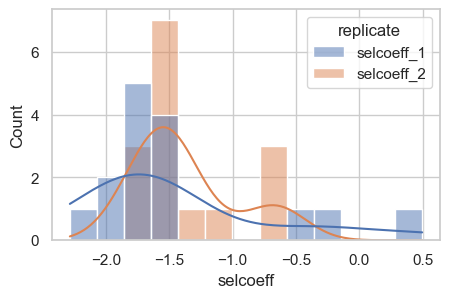

In [46]:
synLong = pd.melt(synOnly, id_vars = 'nt_seq', value_vars = selcoeff_conditions, var_name='replicate', value_name='selcoeff')

# Purge graph space
sns.set(rc = {'figure.figsize':(5,3)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

sns.histplot(synLong, x='selcoeff',
             hue='replicate',
             kde=True)

In [47]:
medianSyn = synOnly[selcoeff_conditions].median().squeeze()
medianSyn

selcoeff_1   -1.650511
selcoeff_2   -1.499537
dtype: float64

In [48]:
withSyndf[selcoeff_conditions] = withSyndf[selcoeff_conditions].subtract(medianSyn, axis=1)
withSyndf[selcoeff_conditions]

,selcoeff_1,selcoeff_2
0,1.775327,1.616623
1,1.812459,1.630035
2,1.731903,1.585633
3,1.971141,1.849932
4,0.209370,-0.023725
...,...,...
521,0.227710,-0.034511
522,0.227710,-0.034511
523,0.227710,-0.034511
524,0.227710,-0.034511


### Compare replicates

Note: here the dataframe is reshaped to have 1 value per nucleotide sequence, with replicates in wide format. To minimize the number of steps, the same dataframe is used to calculate the correlation coefficient (using only the selection coefficients) and to look at the distribution **for single mutants and WT only**. In the "aggregation" notebook, we also take into account variants with >1 mutation (either all mutation are of the same type i.e. synonymous/stop/non-synonymous, or the variant is categorized as 'mixed').

In [49]:
gby_cols = ['seq_type','mutation_type','aa_seq','nt_seq']
permut = withSyndf.groupby(gby_cols)[selcoeff_conditions].first().reset_index()
permut.columns = [x[-1] if 'selcoeff' in x else x for x in permut.columns]
permut

,seq_type,mutation_type,aa_seq,nt_seq,1,2
0,WT,synonymous,FLVLSLRDP,tttttagttttatctttgagagatcca,0.227710,-0.034511
1,ortho,non-synonymous,AICSDLRED,gctatttgttctgatttgagagaagat,1.779506,1.673363
2,ortho,non-synonymous,ALALNIKDP,gctttggctttgaatattaaagatcca,2.060963,1.995049
3,ortho,non-synonymous,ALTLSFRDP,gctttgactttgtcttttagagatcca,2.102678,1.869720
4,ortho,non-synonymous,FLALNLSDS,tttttggctttgaatttgtctgattct,2.079231,1.831659
...,...,...,...,...,...,...
356,single,synonymous,FLVLSLRDP,tttttagttttatctttgagagatcct,-0.167104,-0.014163
357,single,synonymous,FLVLSLRDP,tttttagttttatctttgagggatcca,-0.058870,0.000000
358,single,synonymous,FLVLSLRDP,tttttagttttatctttgcgtgatcca,2.146275,0.901278
359,single,synonymous,FLVLSLRDP,tttttagttttgtctttgagagatcca,-0.321669,-0.303087


In [50]:
import itertools
rep_combinations = list(itertools.combinations(permut.columns[len(gby_cols):], 2))
rep_combinations

[('1', '2')]

In [51]:
from scipy import stats

pearson_dict = {}
for c in rep_combinations:
    pearson_dict[c] = stats.pearsonr(permut[c[0]], permut[c[1]])[0]
    # One possibility is to calculate this for stop, non-synonymous and synonymous separately
    # Pearson r for non-synonymous is the most important (the most affected by distribution of effects)
    # Depending on the level of noise, we could select the two lowest values, see if it's above a fixed threshold (both should be above .8)
    # then see which replicate was common to the 2 corresponding combinations and calculate the median from the two remaining
    
pearson_dict

{('1', '2'): 0.9693439494616387}

In [52]:
permutlong = pd.melt(permut[permut.seq_type.isin(['WT','single'])], id_vars = gby_cols, value_vars = [x[-1] for x in selcoeff_conditions], var_name='replicate', value_name='selcoeff')
permutlong

,seq_type,mutation_type,aa_seq,nt_seq,replicate,selcoeff
0,WT,synonymous,FLVLSLRDP,tttttagttttatctttgagagatcca,1,0.227710
1,single,non-synonymous,ALVLSLRDP,gcgttagttttatctttgagagatcca,1,2.054333
2,single,non-synonymous,ALVLSLRDP,gctttagttttatctttgagagatcca,1,1.841505
3,single,non-synonymous,DLVLSLRDP,gatttagttttatctttgagagatcca,1,1.970476
4,single,non-synonymous,ELVLSLRDP,gagttagttttatctttgagagatcca,1,2.018884
...,...,...,...,...,...,...
529,single,synonymous,FLVLSLRDP,tttttagttttatctttgagagatcct,2,-0.014163
530,single,synonymous,FLVLSLRDP,tttttagttttatctttgagggatcca,2,0.000000
531,single,synonymous,FLVLSLRDP,tttttagttttatctttgcgtgatcca,2,0.901278
532,single,synonymous,FLVLSLRDP,tttttagttttgtctttgagagatcca,2,-0.303087


In [53]:
permutlong.loc[permutlong.seq_type=='WT', 'mutation_type'] = 'WT'
permutlong.head(1)

,seq_type,mutation_type,aa_seq,nt_seq,replicate,selcoeff
0,WT,WT,FLVLSLRDP,tttttagttttatctttgagagatcca,1,0.22771


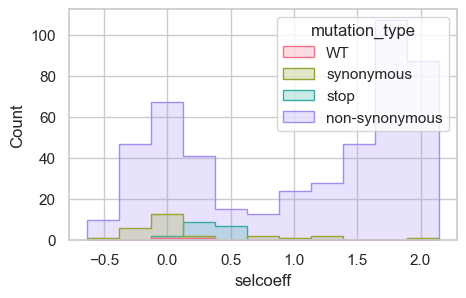

In [54]:
# Purge graph space
sns.set(rc = {'figure.figsize':(5,3)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

fig = sns.histplot(permutlong, x='selcoeff',
                   hue='mutation_type', hue_order=['WT','synonymous','stop','non-synonymous'], palette='husl',
                   element='step', common_norm=False)

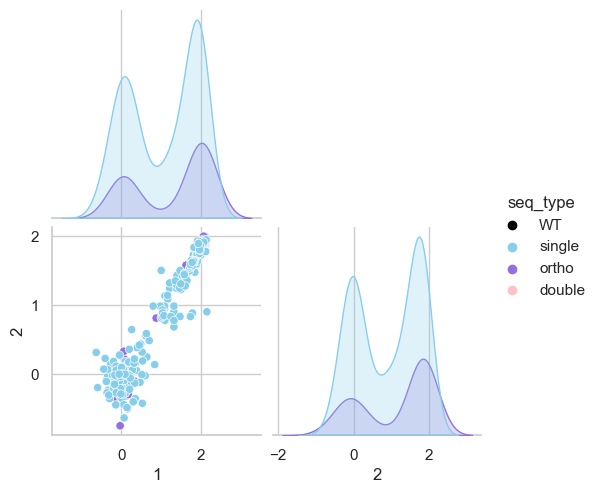

In [55]:
# Purge graph space
sns.set(rc = {'figure.figsize':(5,3)})
sns.set_theme(style='whitegrid')

seq_types = ['WT', 'single', 'ortho', 'double']
seq_type_colors = ['black', 'skyblue', 'mediumpurple', 'pink']

fig = sns.pairplot(permut,
                   hue='seq_type', hue_order=seq_types, palette=seq_type_colors,
                   corner=True)

# Code below does not work for all possible scenarios (replicate# does not necessarily match with facet#)
#for i in range(len(permut.columns[2:])):
#    for j in range(len(permut.columns[2:])):
#        if i < j:
#            fig.axes[j][i].annotate(round(pearson_dict[(str(i+1),str(j+1))],2), (-3,1))

### Drop replicate if uncorrelated

#### /!\ **Filtering step** /!\

In [56]:
pearson_lowest = sorted(pearson_dict.items(), key=lambda x:x[1])
if len(pearson_lowest) == 3:
    if (pearson_lowest[0][1] < .8) & (pearson_lowest[1][1] < .8):
        selcoeff_conditions.remove(f'selcoeff_{"".join(set(pearson_lowest[0][0]) & set(pearson_lowest[1][0]))}')

### Calculate median selection coefficient

In [57]:
withSyndf['median_s'] = withSyndf[selcoeff_conditions].median(axis=1)
withSyndf[selcoeff_conditions+['median_s']]

,selcoeff_1,selcoeff_2,median_s
0,1.775327,1.616623,1.695975
1,1.812459,1.630035,1.721247
2,1.731903,1.585633,1.658768
3,1.971141,1.849932,1.910536
4,0.209370,-0.023725,0.092822
...,...,...,...
521,0.227710,-0.034511,0.096600
522,0.227710,-0.034511,0.096600
523,0.227710,-0.034511,0.096600
524,0.227710,-0.034511,0.096600


### Export dataframe

In [58]:
withSyndf.to_csv(processed_data_outpath+cset_name+'/selcoeff_all_libraries.csv')

### Visualize single mutants as heatmap (codon level)

In [59]:
withWTdf = withSyndf[withSyndf.seq_type.isin(['WT','single'])]
withWTdf

,seq_type,nt_seq,aa_pos,alt_codons,mutated_codon,combination,aa_seq,WT,STOP,STOP_readthrough,...,b1_log10,b2_log10,b3_log10,alt_aa,mutation_type,Log2FC_1,Log2FC_2,selcoeff_1,selcoeff_2,median_s
0,single,ttgttagttttatctttgagagatcca,0.0,ttg,1.0,NaN,LLVLSLRDP,<NA>,False,False,...,-2.274870,-2.296938,-2.250830,L,non-synonymous,0.477418,0.454792,1.775327,1.616623,1.695975
1,single,cttttagttttatctttgagagatcca,0.0,ctt,1.0,NaN,LLVLSLRDP,<NA>,False,False,...,-2.884177,-2.896945,-2.904751,L,non-synonymous,0.619447,0.506887,1.812459,1.630035,1.721247
2,single,ctgttagttttatctttgagagatcca,0.0,ctg,1.0,NaN,LLVLSLRDP,<NA>,False,False,...,-2.755082,-2.741838,-2.792778,L,non-synonymous,0.311325,0.334419,1.731903,1.585633,1.658768
3,single,attttagttttatctttgagagatcca,0.0,att,1.0,NaN,ILVLSLRDP,<NA>,False,False,...,-2.109871,-2.114039,-2.115565,I,non-synonymous,1.226402,1.361026,1.971141,1.849932,1.910536
4,single,atgttagttttatctttgagagatcca,0.0,atg,1.0,NaN,MLVLSLRDP,<NA>,False,False,...,-4.160848,-4.269038,-4.135200,M,non-synonymous,-5.512332,-5.916748,0.209370,-0.023725,0.092822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
521,WT,tttttagttttatctttgagagatcca,4.0,tct,NaN,NaN,FLVLSLRDP,True,NaN,NaN,...,NaN,NaN,NaN,S,synonymous,-5.442180,-5.958644,0.227710,-0.034511,0.096600
522,WT,tttttagttttatctttgagagatcca,5.0,ttg,NaN,NaN,FLVLSLRDP,True,NaN,NaN,...,NaN,NaN,NaN,L,synonymous,-5.442180,-5.958644,0.227710,-0.034511,0.096600
523,WT,tttttagttttatctttgagagatcca,6.0,aga,NaN,NaN,FLVLSLRDP,True,NaN,NaN,...,NaN,NaN,NaN,R,synonymous,-5.442180,-5.958644,0.227710,-0.034511,0.096600
524,WT,tttttagttttatctttgagagatcca,7.0,gat,NaN,NaN,FLVLSLRDP,True,NaN,NaN,...,NaN,NaN,NaN,D,synonymous,-5.442180,-5.958644,0.227710,-0.034511,0.096600


#### Pivot and sort by aminoacid (properties) and codon (alphabetical)

In [60]:
codon_table = pd.read_csv(codon_table_path, header=0)
codon_table['codon'] = codon_table['codon'].str.lower()
codon_table.sort_values(by='codon', inplace=True)
list_codons = codon_table.codon.unique()
cod_sort_dic = dict(zip(list_codons, list(range(0, len(list_codons)))))

aa_sort_order = '*PGCQNTSEDKHRWYFMLIVA'
aa_sort_dic = dict(zip(list(aa_sort_order), list(range(0,len(aa_sort_order)))))

aa_sort_dic.update(cod_sort_dic)

In [61]:
wide_single = withWTdf.pivot(index=['alt_aa','alt_codons'], columns='aa_pos', values='median_s')
wide_single.sort_index(key=lambda x: x.map(aa_sort_dic), inplace=True)
wide_single

aa_pos                  0.0       1.0       2.0       3.0       4.0       5.0  \
alt_aa alt_codons                                                               
*      tag         0.259578  0.178191 -0.026721  0.361047  0.458922  0.237055   
P      cca              NaN       NaN       NaN       NaN       NaN       NaN   
       ccg         1.943813 -0.242945  1.697156 -0.202852  1.911803 -0.121078   
       cct         1.880928  0.450103  1.693550       NaN  1.962909  0.067655   
G      ggg         2.001469  0.287040  1.000247       NaN  0.132626       NaN   
       ggt              NaN  0.188331 -0.029757       NaN  1.248503 -0.325952   
C      tgt              NaN -0.251829 -0.283251  0.174735  1.454524  0.074033   
Q      cag         1.967108  0.050453 -0.014208 -0.172889  1.903705  1.946007   
N      aat         1.332057 -0.035272  1.282732  0.169321  1.959743 -0.135794   
T      acg         1.351319  1.508107  0.422440 -0.159226  1.863208 -0.010470   
       act         1.917937  1.438394 -0.203582 -0.396287  1.827122 -0.012734   
S      agt         1.282732  0.978955  0.262537 -0.176099       NaN -0.140061   
       tcg         1.988796  0.960088  0.443309  0.278593  0.010418 -0.066025   
       tct         1.916422  0.956153  1.225316 -0.186960  0.096600  0.078405   
E      gag         1.905395 -0.004603 -0.194003  0.009312  1.894715  1.528882   
D      gat         1.868857       NaN  1.152012 -0.228422  1.782023 -0.067943   
K      aag         1.937304  0.191821  1.617327  1.880485  1.883808  1.461180   
H      cat         1.941618  0.591763  1.700931  1.967751  1.945964  1.944719   
R      aga              NaN       NaN       NaN       NaN       NaN       NaN   
       agg         2.034857  1.516816  1.410190  1.697975  1.313953  1.931141   
       cgg         1.944763  1.500907  1.616721       NaN  1.977720       NaN   
       cgt              NaN  1.499925  1.782646  1.731957  1.939483  1.904478   
W      tgg         1.397303  0.253729  0.931784  1.965572  0.905714  1.673316   
Y      tat         1.910604  0.082975  0.605951  1.926014  1.855318 -0.119124   
F      ttt         0.096600 -0.167951 -0.076950  1.918752  1.900361  0.101638   
M      atg         0.092822  0.007388 -0.102867 -0.126143  1.436101  0.018930   
L      ctg         1.658768 -0.315984 -0.168832 -0.160469  1.417820  0.081917   
       ctt         1.721247  0.011497 -0.180045  0.048888  1.402781  0.045042   
       tta              NaN  0.096600       NaN  0.096600       NaN       NaN   
       ttg         1.695975 -0.150671 -0.169173 -0.312378  1.394858  0.096600   
I      att         1.910536  0.021930  0.095519 -0.082407  1.802082 -0.108951   
V      gtg         1.881072  0.198322  1.037702  0.889406  0.978043 -0.082560   
       gtt              NaN  0.060256  0.096600  0.091255  1.148646 -0.293568   
A      gcg         1.990006  0.257610  0.021461  1.150845  0.063630 -0.173451   
       gct         1.657686  0.583777  1.109405 -0.283717  0.138695 -0.092180   

aa_pos                  6.0       7.0       8.0  
alt_aa alt_codons                                
*      tag         0.271975  0.389816  0.434488  
P      cca              NaN       NaN  0.096600  
       ccg         1.427645  1.905600  1.046919  
       cct         1.511196  1.918151 -0.090634  
G      ggg         1.910682  1.899963  1.738773  
       ggt         1.879828  1.263877  1.680619  
C      tgt         0.078092  1.927927  1.484760  
Q      cag        -0.007285  1.739328       NaN  
N      aat         0.394006  1.017113       NaN  
T      acg         0.122181  1.955277  1.782954  
       act         0.215168  1.915798  1.889500  
S      agt         0.992874  1.932787  1.602920  
       tcg         1.033941  1.953974  1.624557  
       tct         0.418239  1.948224  1.650773  
E      gag         0.051485  1.694431  1.925554  
D      gat         0.112723  0.096600  1.909683  
K      aag        -0.006069  1.818059  1.764053  
H      cat         0.932608  1.926229  1.875654  
R 

#### Generate heatmap

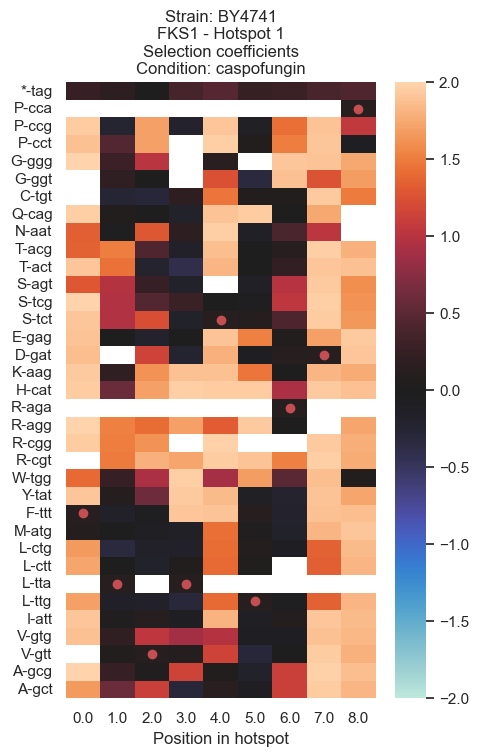

In [62]:
# Purge graph space
sns.set(rc = {'figure.figsize':(5,8)})
sns.set_theme(style='white')
f, ax = plt.subplots()

ax = sns.heatmap(wide_single, cmap='icefire', center = 0,
                 vmin=-2,
                 vmax=2
                )
ax.set_xlabel('Position in hotspot')
ax.set_ylabel(None)
ax.set_title('Strain: '+strain+
             '\n'+locus[:4]+' - Hotspot '+locus[-1]+
             '\nSelection coefficients'+
             '\nCondition: '+compound)

# Coordinates of WT codons on the heatmap are extracted from the dataframe
# Coordinates should be OK even if some codons are missing from the dataframe
codon_list = [x[1] for x in wide_single.index]
wtcoord = [((i//3)+0.5,codon_list.index(wtseq[i:i+3])+0.5) for i in range(0,len(wtseq),3)]

for o in wtcoord:
    ax.plot(o[0],o[1],'or') # displays WT codons by marking them with red (r) circles (o)
    
# Graphs are output in the specified folder
plt.savefig(graph_outpath+cset_name+'/nt_heatmap_median_s.svg', format='svg', dpi=300)

### Aggregate at protein level

### Visualize single mutants as heatmap (protein level)

In [63]:
aa_single = withWTdf.groupby(['alt_aa','aa_pos'])[['median_s']].median().reset_index()
wide_aa = aa_single.pivot(index='alt_aa', columns='aa_pos', values='median_s')
wide_aa.sort_index(key=lambda x: x.map(aa_sort_dic), inplace=True)
wide_aa

aa_pos,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0
alt_aa,,,,,,,,,
*,0.259578,0.178191,-0.026721,0.361047,0.458922,0.237055,0.271975,0.389816,0.434488
P,1.912371,0.103579,1.695353,-0.202852,1.937356,-0.026712,1.469421,1.911875,0.096600
G,2.001469,0.237685,0.485245,NaN,0.690565,-0.325952,1.895255,1.581920,1.709696
C,NaN,-0.251829,-0.283251,0.174735,1.454524,0.074033,0.078092,1.927927,1.484760
Q,1.967108,0.050453,-0.014208,-0.172889,1.903705,1.946007,-0.007285,1.739328,NaN
N,1.332057,-0.035272,1.282732,0.169321,1.959743,-0.135794,0.394006,1.017113,NaN
T,1.634628,1.473251,0.109429,-0.277757,1.845165,-0.011602,0.168675,1.935538,1.836227
S,1.916422,0.960088,0.443309,-0.176099,0.053509,-0.066025,0.992874,1.948224,1.624557
E,1.905395,-0.004603,-0.194003,0.009312,1.894715,1.528882,0.051485,1.694431,1.925554


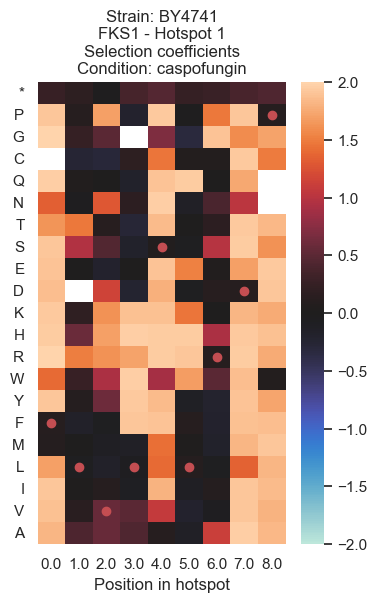

In [64]:
# Purge graph space
sns.set(rc = {'figure.figsize':(4,6)})
sns.set_theme(style='white')
f, ax = plt.subplots()

ax = sns.heatmap(wide_aa, cmap='icefire', center = 0,
                 vmin=-2,
                 vmax=2
                )
ax.set_xlabel('Position in hotspot')
ax.set_ylabel(None)
plt.yticks(rotation=0)
ax.set_title('Strain: '+strain+
             '\n'+locus[:4]+' - Hotspot '+locus[-1]+
             '\nSelection coefficients'+
             '\nCondition: '+compound)

# Coordinates of WT protein sequence on the heatmap are extracted from the dataframe
# Coordinates should be OK even if the dataframe contains missing values
wtcoord_aa = [(i+0.5, list(aa_sort_order).index(v)+0.5) for i,v in enumerate(wtaa)]

for o in wtcoord_aa:
    ax.plot(o[0],o[1],'or') # displays WT codons by marking them with red (r) circles (o)
    
# Graphs are output in the specified folder
plt.savefig(graph_outpath+cset_name+'/aa_heatmap_median_s.svg', format='svg', dpi=300)

### Compare with DiMSum-corrected fitness values

```
dimsum_single = pd.read_csv(variantdata_path+cset_name+'_fitness_singles.txt', sep=' ')
dimsum_single.rename(columns={'Pos':'aa_pos', 'Mut':'alt_aa'}, inplace=True)
dimsum_single['aa_pos'] -= 1
dimsum_single
```

```
dimsum_compare = pd.merge(left=aa_single, right=dimsum_single, how='outer', on=['aa_pos','alt_aa'], indicator='Location')
dimsum_compare
```

```
dimsum_compare[dimsum_compare.Location != 'both']
```

```
# Purge graph space
sns.set(rc = {'figure.figsize':(4,4)})
sns.set_theme(style='whitegrid')
fig = sns.relplot(dimsum_compare[dimsum_compare.Location == 'both'], x='median_s', y='fitness',
                   #hue='aa_pos', palette='hls'
                  )
fig.set(xlim=(-1,5.5), ylim=(-1,5.5), xlabel='median selection coefficient', ylabel='DiMSum-corrected fitness')
fig.axes[0][0].axline((1,1), slope=1, linestyle='--', c='.8', zorder=-10)
```

### With orthologs

```
fitness = abundf.groupby(['seq_type', 'aa_seq', 'aa_pos', 'alt_aa', 'Nham_aa']).agg(median_s = ('median_s', 'median')).reset_index()
fitness.sort_values(by=['aa_pos', 'alt_aa'], inplace=True)
fitness
```

### Per unique protein sequence

```
byseq_fit = fitness.groupby(['aa_seq', 'Nham_aa']).agg(s_nb_val = ('median_s', 'nunique'), s = ('median_s', 'median'))
byseq_fit.sort_values(by='Nham_aa', inplace=True)
```

```
# Purge graph space
sns.set(rc = {'figure.figsize':(5,3)})
sns.set_theme(style='whitegrid')
f, ax = plt.subplots()

sns.histplot(byseq_fit, x='s', hue='Nham_aa', kde=True)
plt.xlim(-1, 4)
```